In [37]:
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
import sklearn.model_selection as ml
from statistics import mode



In [21]:
cancer_dataset = pd.read_csv("datasets/cancer.csv")
cancer_labels = [1 if val == 'M' else 0 for val in cancer_dataset['label'].values]
cancer_points = cancer_dataset.drop(['label'], axis=1).values


In [22]:
spam_dataset = pd.read_csv("datasets/spam.csv")
spam_labels = [val for val in spam_dataset['label'].values]
spam_points = spam_dataset.drop(['label'], axis=1).values


In [23]:
# Util function -- count AUC
def auc_calc(x_arr, y_arr):
    prev_x = None
    prev_y = None
    result = 0
    for x, y in zip(x_arr, y_arr):
        if prev_x is not None:
            result += ((prev_x + x) * (y - prev_y)) / 2
        prev_x = x
        prev_y = y
    return result


In [24]:
def roc_points(col_data, labels):
    true_positive_perc = list()
    false_positive_perc = list()

    true_positive = labels.count(1)
    false_positive = labels.count(0)
    prev_feature = None
    for dividing_ind, (feature, label) in enumerate(sorted(zip(col_data, labels))):
        if prev_feature != feature and prev_feature is not None:
            false_positive_perc.append(false_positive / labels.count(0))
            true_positive_perc.append(true_positive / labels.count(1))
        prev_feature = feature

        if label == 1:
            true_positive -= 1
        else:
            false_positive -= 1
    false_positive_perc.append(false_positive / labels.count(0))
    true_positive_perc.append(true_positive / labels.count(1))

    return list(reversed(true_positive_perc)), list(reversed(false_positive_perc))


In [25]:
def top_3(data, labels):
    col_results = list()
    for col in range(data.shape[1]):
        true_positive, false_positive = roc_points(data[:, col], labels)
        auc = auc_calc(true_positive, false_positive)
        col_results.append((auc, col, (true_positive, false_positive)))

    top_3_res = heapq.nlargest(3, col_results)
    for auc, col, (true_positive, false_positive) in sorted(top_3_res, key=lambda x: x[1]):
        plt.plot(false_positive, true_positive)
        plt.show()
        print(f'AUC for col {col} is {auc}\n')


For Cancer dataset:



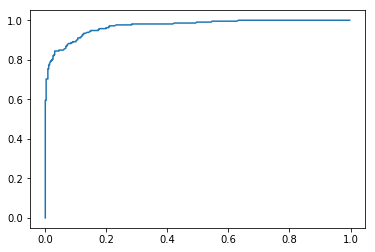

AUC for col 20 is 0.967641773690608



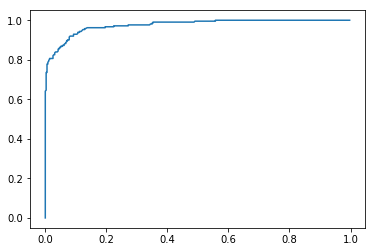

AUC for col 22 is 0.9726494371333434



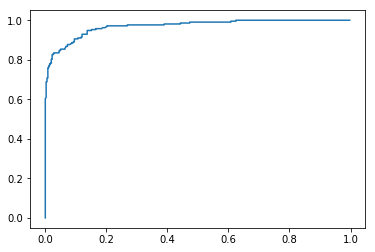

AUC for col 23 is 0.9670273769885313



In [26]:

print("For Cancer dataset:\n")
top_3(cancer_points, cancer_labels)

For Spam dataset:



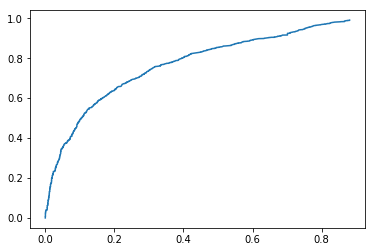

AUC for col 54 is 0.6700666753187762



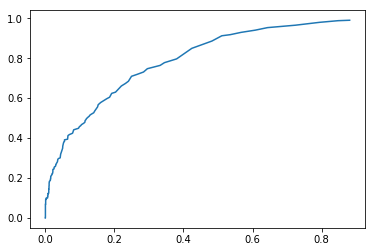

AUC for col 55 is 0.6860288281429908



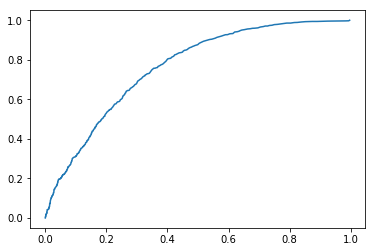

AUC for col 56 is 0.7590519727996674



In [27]:
print("For Spam dataset:\n")
top_3(spam_points, spam_labels)

In [35]:
cancer_points_training, cancer_points_test, cancer_labels_training, cancer_labels_test = ml.train_test_split(cancer_points, cancer_labels, train_size=0.8)
print(f'In Cancer training: {np.count_nonzero(cancer_labels_training) / np.size(cancer_labels_training)}')
print(f'In Cancer test: {np.count_nonzero(cancer_labels_test) / np.size(cancer_labels_test)}')



In Cancer training: 0.378021978021978
In Cancer test: 0.3508771929824561


In [36]:
spam_points_training, spam_points_test, spam_labels_training, spam_labels_test = ml.train_test_split(spam_points, spam_labels, train_size=0.8)
print(f'In spam training: {np.count_nonzero(spam_labels_training) / np.size(spam_labels_training)}')
print(f'In spam test: {np.count_nonzero(spam_labels_test) / np.size(spam_labels_test)}')

In spam training: 0.3948369565217391
In spam test: 0.39087947882736157


In [48]:
class DecTree:
    def __init__(self, data, labels, max_depth, impurity):
        self.max = max_depth
        self.impurity = impurity
        self.data = data
        self.labels = labels

        self.node_value = max(((list(labels).count(val), val) for val in set(labels)))[1]
        self.subtree_depth = 0
        self.left_tree = None
        self.right_tree = None

        self.col_ind = None
        self.dividing_value = None
        self.max_metric = None

        if self.max != 0:
            self.precalc()

    def node_impurity(self):
        return self.impurity(self.labels) * len(self.labels)

    def precalc(self):
        for col_ind in range(self.data.shape[1]):
            feature_value_set = set(self.data[:, col_ind])
            for possible_dividing in feature_value_set:
                if possible_dividing == max(feature_value_set) or possible_dividing == min(feature_value_set):
                    continue
                left_labels = self.labels[self.data[:, col_ind] < possible_dividing]
                right_labels = self.labels[self.data[:, col_ind] >= possible_dividing]
                cur_metric = self.node_impurity() - self.impurity(left_labels) * len(left_labels) - self.impurity(
                    right_labels) * len(right_labels)
                if self.max_metric is None or self.max_metric < cur_metric:
                    self.max_metric = cur_metric
                    self.col_ind = col_ind
                    self.dividing_value = possible_dividing
        if self.max_metric is not None and self.max_metric > 0:
            new_max = self.max - 1
            left_part = self.data[:, self.col_ind] < self.dividing_value
            right_part = self.data[:, self.col_ind] >= self.dividing_value
            self.left_tree = DecTree(self.data[left_part], self.labels[left_part], new_max, self.impurity)
            self.right_tree = DecTree(self.data[right_part], self.labels[right_part], new_max, self.impurity)
            self.subtree_depth = max(self.left_tree.subtree_depth, self.right_tree.subtree_depth) + 1

    def classify(self, data):
        result = np.zeros(data.shape[0])
        if self.left_tree is None and self.right_tree is None:
            result.fill(self.node_value)
        else:
            left_part = data[:, self.col_ind] < self.dividing_value
            right_part = data[:, self.col_ind] >= self.dividing_value
            result[left_part] = self.left_tree.classify(data[left_part])
            result[right_part] = self.right_tree.classify(data[right_part])
        return result


In [49]:
def miss_error(labels):
    lst_labels = list(labels)
    return 1 - max((lst_labels.count(val) for val in set(lst_labels))) / len(labels)


def entropy(labels):
    lst_labels = list(labels)
    result = 0
    for cur_label_num in (lst_labels.count(val) for val in set(lst_labels)):
        cur_label_perc = cur_label_num / len(labels)
        result -= cur_label_perc * np.log(cur_label_perc)
    return result


def gini_impurity(labels):
    lst_labels = list(labels)
    result = 0
    for cur_label_num in (lst_labels.count(val) for val in set(lst_labels)):
        cur_label_perc = cur_label_num / len(labels)
        result += cur_label_perc * (1 - cur_label_perc)
    return result


In [50]:
def dec_tree_best(points_training, labels_training, points_test, labels_test, impurity):
    for max_depth in range(1, 11):
        classifier = DecTree(points_training, labels_training, max_depth, impurity)
        result = classifier.classify(points_test)
        print(f"Tree depth: {classifier.subtree_depth}; Max depth: {max_depth}; Acc: {np.mean(result == labels_test)}")


In [45]:

print("For Cancer dataset")


For Cancer dataset


In [46]:
print("With Missclassification error")
dec_tree_best(cancer_points_training, np.array(cancer_labels_training), cancer_points_test, np.array(cancer_labels_test), miss_error)


With Missclassification error


Tree depth: 1; Max depth: 1; Acc: 0.9122807017543859


Tree depth: 2; Max depth: 2; Acc: 0.956140350877193


Tree depth: 3; Max depth: 3; Acc: 0.9385964912280702


Tree depth: 4; Max depth: 4; Acc: 0.9385964912280702


Tree depth: 5; Max depth: 5; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 6; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 7; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 8; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 9; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 10; Acc: 0.9298245614035088


In [51]:
print("With Entropy")
dec_tree_best(cancer_points_training, np.array(cancer_labels_training), cancer_points_test, np.array(cancer_labels_test), entropy)

With Entropy


Tree depth: 1; Max depth: 1; Acc: 0.9122807017543859


Tree depth: 2; Max depth: 2; Acc: 0.9122807017543859


Tree depth: 3; Max depth: 3; Acc: 0.9298245614035088


Tree depth: 4; Max depth: 4; Acc: 0.956140350877193


Tree depth: 5; Max depth: 5; Acc: 0.9298245614035088


Tree depth: 6; Max depth: 6; Acc: 0.9385964912280702


Tree depth: 6; Max depth: 7; Acc: 0.9385964912280702


Tree depth: 6; Max depth: 8; Acc: 0.9385964912280702


Tree depth: 6; Max depth: 9; Acc: 0.9385964912280702


Tree depth: 6; Max depth: 10; Acc: 0.9385964912280702


In [52]:
print("With Gini impurity")
dec_tree_best(cancer_points_training, np.array(cancer_labels_training), cancer_points_test, np.array(cancer_labels_test), gini_impurity)

With Gini impurity


Tree depth: 1; Max depth: 1; Acc: 0.9122807017543859


Tree depth: 2; Max depth: 2; Acc: 0.9385964912280702


Tree depth: 3; Max depth: 3; Acc: 0.9473684210526315


Tree depth: 4; Max depth: 4; Acc: 0.9298245614035088


Tree depth: 5; Max depth: 5; Acc: 0.9473684210526315


Tree depth: 6; Max depth: 6; Acc: 0.9473684210526315


Tree depth: 7; Max depth: 7; Acc: 0.9473684210526315


Tree depth: 7; Max depth: 8; Acc: 0.9473684210526315


Tree depth: 7; Max depth: 9; Acc: 0.9473684210526315


Tree depth: 7; Max depth: 10; Acc: 0.9473684210526315


In [53]:
print("For Spam dataset")


For Spam dataset


In [54]:
print("With Missclassification error")
dec_tree_best(spam_points_training, np.array(spam_labels_training), spam_points_test, np.array(spam_labels_test), miss_error)


With Missclassification error


Tree depth: 1; Max depth: 1; Acc: 0.8034744842562432


Tree depth: 2; Max depth: 2; Acc: 0.8773072747014115


Tree depth: 3; Max depth: 3; Acc: 0.9098805646036916


Tree depth: 4; Max depth: 4; Acc: 0.9229098805646037


Tree depth: 5; Max depth: 5; Acc: 0.9153094462540716


Tree depth: 6; Max depth: 6; Acc: 0.9207383279044516


Tree depth: 7; Max depth: 7; Acc: 0.9239956568946797


Tree depth: 8; Max depth: 8; Acc: 0.9250814332247557


Tree depth: 9; Max depth: 9; Acc: 0.9250814332247557


Tree depth: 10; Max depth: 10; Acc: 0.9239956568946797


In [55]:
print("With Entropy")
dec_tree_best(spam_points_training, np.array(spam_labels_training), spam_points_test, np.array(spam_labels_test), entropy)


With Entropy


Tree depth: 1; Max depth: 1; Acc: 0.7980456026058632


Tree depth: 2; Max depth: 2; Acc: 0.8382193268186754


Tree depth: 3; Max depth: 3; Acc: 0.8718783930510315


Tree depth: 4; Max depth: 4; Acc: 0.8881650380021715


Tree depth: 5; Max depth: 5; Acc: 0.9001085776330076


Tree depth: 6; Max depth: 6; Acc: 0.9077090119435396


Tree depth: 7; Max depth: 7; Acc: 0.9142236699239956


Tree depth: 8; Max depth: 8; Acc: 0.9185667752442996


Tree depth: 9; Max depth: 9; Acc: 0.9239956568946797


Tree depth: 10; Max depth: 10; Acc: 0.9272529858849077


In [56]:
print("With Gini impurity")
dec_tree_best(spam_points_training, np.array(spam_labels_training), spam_points_test, np.array(spam_labels_test), gini_impurity)


With Gini impurity


Tree depth: 1; Max depth: 1; Acc: 0.7980456026058632


Tree depth: 2; Max depth: 2; Acc: 0.8425624321389794


Tree depth: 3; Max depth: 3; Acc: 0.8892508143322475


Tree depth: 4; Max depth: 4; Acc: 0.9011943539630836


Tree depth: 5; Max depth: 5; Acc: 0.9142236699239956


Tree depth: 6; Max depth: 6; Acc: 0.9196525515743756


Tree depth: 7; Max depth: 7; Acc: 0.9229098805646037


Tree depth: 8; Max depth: 8; Acc: 0.9207383279044516


Tree depth: 9; Max depth: 9; Acc: 0.9174809989142236


Tree depth: 10; Max depth: 10; Acc: 0.9261672095548317
